In [151]:
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

In [153]:
data = np.load('../test_data/test_data.npz', allow_pickle=True)
volume = data["volume"]

In [154]:
#Set pixels that are 0 to 1.33
volume[volume == 0] = 1.33

#Set the pixels that are not 0 to range from 1.36 to 1.42 ie. min and max of the pixel values in the volume is 1.33 and 1.42
volume[volume != 1.33] = volume[volume != 1.33] / np.max(volume[volume != 1.33]) * 0.06 + 1.36


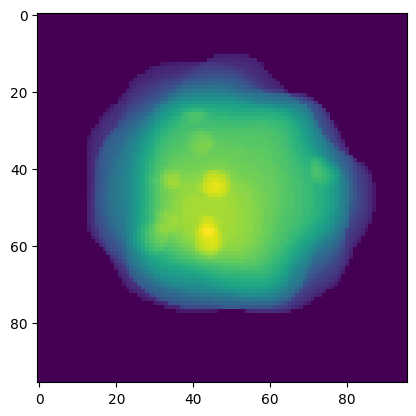

In [155]:
plt.imshow(volume.sum(axis=0))

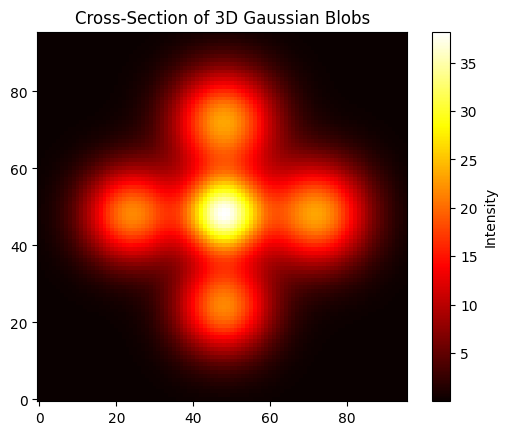

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Grid size
size = 96
grid = np.zeros((size, size, size))

# Gaussian blob parameters
centers = [(24, 48, 48), (72, 48, 48), (48, 24, 48), 
           (48, 72, 48), (48, 48, 24), (48, 48, 72),
           ]  # Center positions
sigma = 8  # Standard deviation (spread of blobs)

# Generate blobs
sigma_random = np.random.uniform(4, 10, len(centers))
for i, center in enumerate(centers):
    x, y, z = np.indices((size, size, size))  # 3D coordinates
    blob = np.exp(-((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2) / (2 * sigma_random[i]**2))
    grid += blob  # Add each blob to the grid

# Normalize the grid for visualization
grid /= grid.max()

# Plot a 2D cross-section at z=48
plt.imshow(grid.sum(axis=2), cmap="hot", origin="lower")
plt.colorbar(label="Intensity")
plt.title("Cross-Section of 3D Gaussian Blobs")
plt.show()



In [157]:
#Scale the values of the volume to be between 1.33 and 1.45
volume = grid
volume = volume / np.max(volume) * 0.05 + 1.33


In [158]:
volume.max(), volume.min()

(1.3800000000000001, 1.33)

In [159]:
volume.sum(axis=2)

array([[127.68000001, 127.68000001, 127.68000002, ..., 127.68000016,
        127.68000012, 127.68000009],
       [127.68000001, 127.68000002, 127.68000003, ..., 127.68000026,
        127.6800002 , 127.68000015],
       [127.68000002, 127.68000003, 127.68000005, ..., 127.68000044,
        127.68000033, 127.68000025],
       ...,
       [127.68000018, 127.6800003 , 127.6800005 , ..., 127.68000143,
        127.68000097, 127.68000066],
       [127.68000013, 127.68000023, 127.68000038, ..., 127.68000098,
        127.68000066, 127.68000044],
       [127.6800001 , 127.68000017, 127.68000028, ..., 127.68000068,
        127.68000045, 127.68000029]])

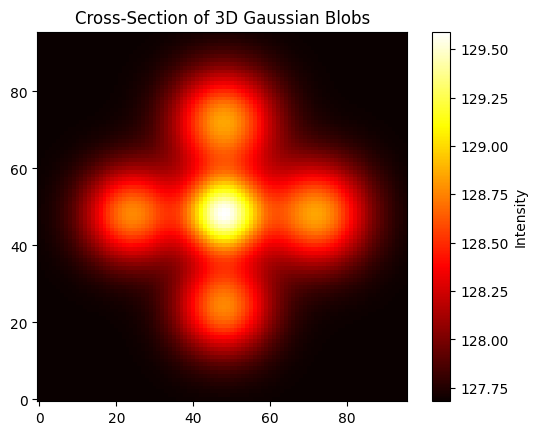

In [160]:
# Plot a 2D cross-section at z=48
plt.imshow(volume.sum(axis=2), cmap="hot", origin="lower")
plt.colorbar(label="Intensity")
plt.title("Cross-Section of 3D Gaussian Blobs")
plt.show()

In [161]:
def setup_optics(nsize, NA=0.7, wavelength=532e-9, resolution=100e-9, magnification=1, return_field=True):
    """
    Set up the optical system, prepare simulation parameters, and compute the optical image.

    Args:
        nsize (int): Size of the volume grid.
        NA (float): Numerical aperture of the objective (default 0.7).
        wavelength (float): Wavelength of light in meters (default 532 nm).
        resolution (float): Optical resolution in meters (default 100 nm).
        magnification (float): Magnification factor (default 1).
        return_field (bool): Whether to return the optical field (default True).

    Returns:
        dict: A dictionary containing optics object, limits, fields, properties, and computed image.
    """

    # Define the optics
    optics = dt.Brightfield(
        NA=NA,
        wavelength=wavelength,
        resolution=resolution,
        magnification=magnification,
        output_region=(0, 0, nsize, nsize),
        return_field=return_field
    )

    # Define simulation limits
    limits = np.array([[0, nsize], [0, nsize], [-nsize//2, nsize//2]])

    # Define fields
    padded_nsize = ((nsize + 31) // 32) * 32
    fields = np.ones((padded_nsize, padded_nsize), dtype=complex)

    # Extract relevant properties from the optics
    properties = optics.properties()
    filtered_properties = {
        k: v for k, v in properties.items()
        if k in {'padding', 'output_region', 'NA', 'wavelength', 
                 'refractive_index_medium', 'return_field'}
    }

    return {
        "optics": optics,
        "limits": limits,
        "fields": fields,
        "filtered_properties": filtered_properties,
        }

def simulation(optics, object):
    """
    Simulate the imaging process of the optical system.

    Args:
        optics (dict): A dictionary containing the optical system.
        object (np.ndarray): The object to image.

    Returns:
        np.ndarray: The simulated image.
    """

    object = dt.Image(object)

    image = optics['optics'].get(object, optics['limits'], optics['fields'], **optics['filtered_properties'])

    return image


In [162]:
optics = setup_optics(nsize=96, NA=0.7, wavelength=532e-9, resolution=100e-9, magnification=1, return_field=True)
image = simulation(optics, volume)

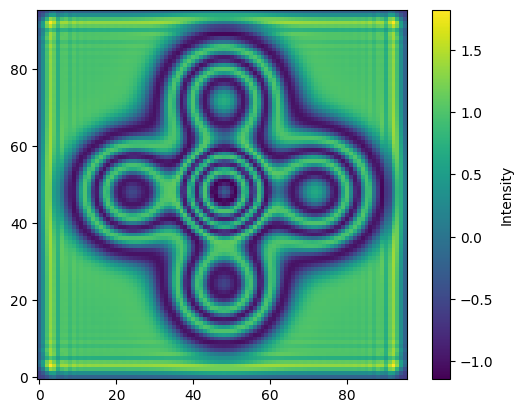

In [163]:
plt.imshow(image.imag, origin="lower")
plt.colorbar(label="Intensity")

In [115]:
import importlib
# From parent directory
import sys
sys.path.append('..')

from OldCode import rotations as R
from OldCode import forward_model as F

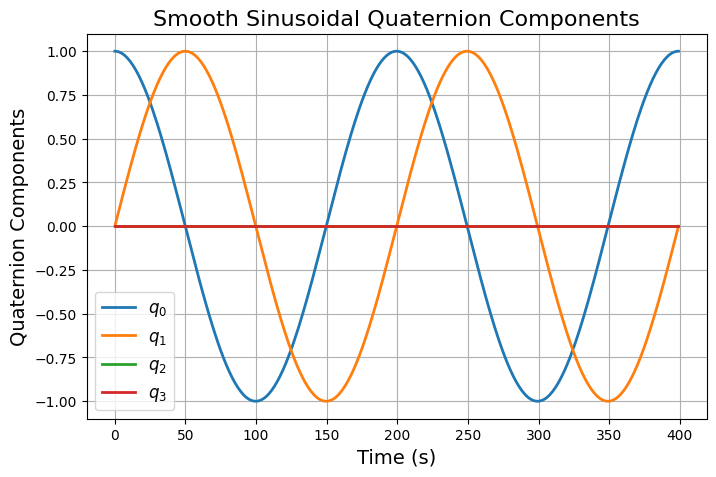

In [127]:
samples = 400
Q_accum = R.generate_sinusoidal_quaternion(omega=2*np.pi, phi=0, psi=0, duration=2, samples=samples)
q0, q1, q2, q3 = Q_accum.T

# Plot the quaternion components over time
plt.figure(figsize=(8, 5))
plt.plot(q0, label=r'$q_0$', linewidth=2)
plt.plot(q1, label=r'$q_1$', linewidth=2)
plt.plot(q2, label=r'$q_2$', linewidth=2)
plt.plot(q3, label=r'$q_3$', linewidth=2)

plt.title("Smooth Sinusoidal Quaternion Components", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Quaternion Components", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Q_accum = np.array([q0, q2, q1, q3]).T

In [128]:
forward_model = F.ForwardModelSimple(volume.shape[1])

In [129]:
import torch

In [130]:
type(forward_model.grid)

torch.Tensor

In [141]:
projections = np.zeros((samples, 1, volume.shape[1], volume.shape[2]))
for i in range(samples):
    print(f"Simulating projection {i+1}/{samples}")
    volume_new = forward_model.apply_rotation(
        volume = torch.tensor(volume, dtype=torch.float32).to('cuda'), 
        q = torch.tensor(Q_accum[i], dtype=torch.float32).to('cuda')
        )
    projections[i,0] = volume_new.sum(axis=2).cpu().numpy()   

Simulating projection 1/400
Simulating projection 2/400
Simulating projection 3/400
Simulating projection 4/400
Simulating projection 5/400
Simulating projection 6/400
Simulating projection 7/400
Simulating projection 8/400
Simulating projection 9/400
Simulating projection 10/400
Simulating projection 11/400
Simulating projection 12/400
Simulating projection 13/400
Simulating projection 14/400
Simulating projection 15/400
Simulating projection 16/400
Simulating projection 17/400
Simulating projection 18/400
Simulating projection 19/400
Simulating projection 20/400
Simulating projection 21/400
Simulating projection 22/400
Simulating projection 23/400
Simulating projection 24/400
Simulating projection 25/400
Simulating projection 26/400
Simulating projection 27/400
Simulating projection 28/400
Simulating projection 29/400
Simulating projection 30/400
Simulating projection 31/400
Simulating projection 32/400
Simulating projection 33/400
Simulating projection 34/400
Simulating projection 3

In [138]:
volume.shape

(96, 96, 96)

In [140]:
volume.sum(axis=2).shape

(96, 96)

In [132]:
projections = np.zeros((samples, 2, volume.shape[1], volume.shape[2]))
for i in range(samples):
    print(f"Simulating projection {i+1}/{samples}")
    volume_new = forward_model.apply_rotation(
        volume = torch.tensor(volume, dtype=torch.float32).to('cuda'), 
        q = torch.tensor(Q_accum[i], dtype=torch.float32).to('cuda')
        )
    image = simulation(optics, volume_new.cpu().numpy())
    projections[i,0] = image.real.squeeze()
    projections[i,1] = image.imag.squeeze()


Simulating projection 1/400
Simulating projection 2/400
Simulating projection 3/400
Simulating projection 4/400
Simulating projection 5/400
Simulating projection 6/400
Simulating projection 7/400
Simulating projection 8/400
Simulating projection 9/400
Simulating projection 10/400
Simulating projection 11/400
Simulating projection 12/400
Simulating projection 13/400
Simulating projection 14/400
Simulating projection 15/400
Simulating projection 16/400
Simulating projection 17/400
Simulating projection 18/400
Simulating projection 19/400
Simulating projection 20/400
Simulating projection 21/400
Simulating projection 22/400
Simulating projection 23/400
Simulating projection 24/400
Simulating projection 25/400
Simulating projection 26/400
Simulating projection 27/400
Simulating projection 28/400
Simulating projection 29/400
Simulating projection 30/400
Simulating projection 31/400
Simulating projection 32/400
Simulating projection 33/400
Simulating projection 34/400
Simulating projection 3

In [122]:
projections.shape

(400, 2, 96, 96)

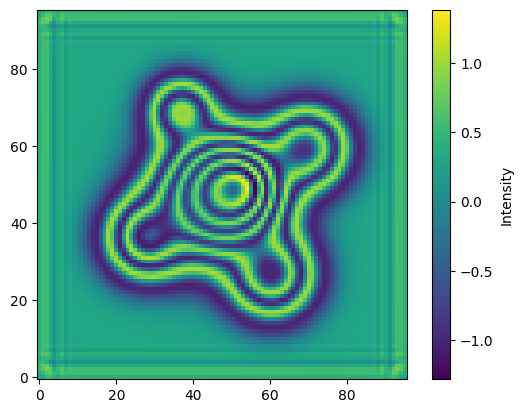

In [126]:
plt.imshow(projections[150].real, origin="lower")
plt.colorbar(label="Intensity")

In [133]:
projections = projections[:,0] + 1j * projections[:,1]

In [142]:
# Save to "projections", "volume" and "quaternions" into a npz file
np.savez("test_data_cf.npz", projections=projections, volume=volume, quaternions=Q_accum)

In [ ]:
projections = projections[:,0] + 1j * projections[:,1]

(128, 128, 1)


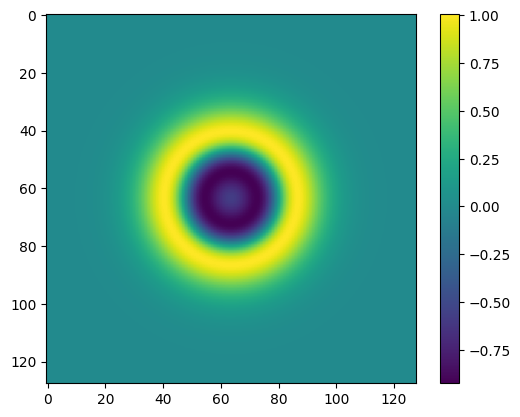

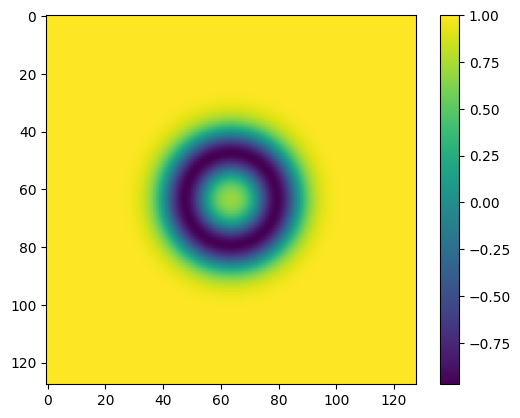

In [39]:
optics=dt.Brightfield(wavelength=532e-9,resolution=100e-9,maginifaction=1,output_region=(0,0,128,128),return_field=True)

Volume=np.zeros((128,128,128))
x,y,z=np.meshgrid(np.linspace(-1,1,128),np.linspace(-1,1,128),np.linspace(-1,1,128))

Volume=.01*np.exp(-(x**2+y**2+z**2)*10)+0j


volume = dt.Image(Volume)
limits = np.array([[0, 128], [0, 128], [0, 128]])
fields = np.array([np.ones((162, 162), dtype=complex)])
properties = optics.properties()
filtered_properties = {
     k: v for k, v in properties.items()
     if k in {'padding', 'output_region', 'NA', 
              'wavelength', 'refractive_index_medium','return_field'}
}
image = optics.get(volume, limits, fields, **filtered_properties)
print(image.shape)
plt.imshow(image.imag)
plt.colorbar()
plt.show()
plt.imshow(image.real)
plt.colorbar()
plt.show()

In [2]:
data = np.load('../test_data/test_data.npz', allow_pickle=True)
volume = data["volume"]

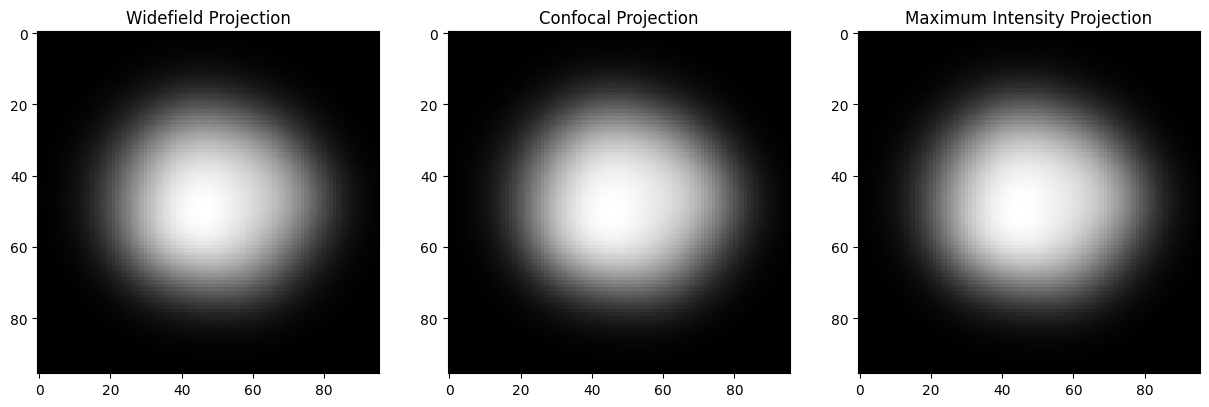

In [3]:
import numpy as np
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt



# Step 2: Generate the PSF
def generate_psf(size=(64, 64, 64), wavelength=0.6, na=1.2, z_scale=2.0):
    z, y, x = np.meshgrid(
        np.linspace(-1, 1, size[0]),
        np.linspace(-1, 1, size[1]),
        np.linspace(-1, 1, size[2]),
        indexing="ij"
    )
    r = np.sqrt(x**2 + y**2)
    psf = np.exp(-r**2 / (2 * (wavelength / (2 * na))**2)) * np.exp(-z**2 / (2 * (z_scale * wavelength / na)**2))
    return psf / psf.sum()

psf_3d = generate_psf()

# Step 3: Convolve the volume with the PSF
blurred_volume = fftconvolve(volume, psf_3d, mode="same")

# Step 4: Project the 3D volume into 2D
widefield_image = np.sum(blurred_volume, axis=0)
confocal_image = blurred_volume[blurred_volume.shape[0] // 2]
mip_image = np.max(blurred_volume, axis=0)

# Step 5: Visualize the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(widefield_image, cmap="gray")
ax[0].set_title("Widefield Projection")

ax[1].imshow(confocal_image, cmap="gray")
ax[1].set_title("Confocal Projection")

ax[2].imshow(mip_image, cmap="gray")
ax[2].set_title("Maximum Intensity Projection")

plt.show()

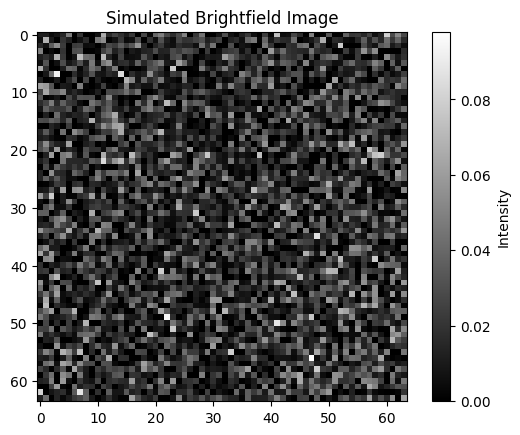

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create a 3D absorption volume
volume_size = (64, 64, 64)
absorption_volume = np.random.rand(*volume_size) * 0.1  # Low absorption
absorption_volume[np.random.rand(*volume_size) > 0.98] = 1.0  # Dense particles

# Step 2: Simulate light transmission through the sample
illumination = 1.0  # Uniform light source
transmitted_light = illumination * np.exp(-np.sum(absorption_volume, axis=0))

# Step 3: Add noise and artifacts
noise = np.random.normal(0, 0.01, transmitted_light.shape)  # Gaussian noise
transmitted_light_noisy = transmitted_light + noise
transmitted_light_noisy = np.clip(transmitted_light_noisy, 0, 1)  # Clip to valid intensity range

# Step 4: Visualize the result
plt.imshow(transmitted_light_noisy, cmap="gray")
plt.title("Simulated Brightfield Image")
plt.colorbar(label="Intensity")
plt.show()
